<a href="https://colab.research.google.com/github/yukilost/googlecolab/blob/main/shoes_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>深層学習を用いたCG・画像処理</strong></h1>

Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


モジュールのインポート

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import csv

使用するデバイスの指定

In [ ]:
device = torch.device("cuda") if torch.cuda_is_available() else torch.device("cpu")

# スクレイピング

## scrape.py

ZOZOから靴の画像、カテゴリ、ブランド、値段を取得する。  
画像のURLを利用してデータが重複しないようにする。  
Google Colaboratoryで実行すると混雑時のページに飛ばされてしまうためローカル環境で実行する必要がある。  
>csvデータの形式  
>[id, url, category, brand, price]

In [ ]:
# scrape.py

import requests
from bs4 import BeautifulSoup
import csv
import time
import re

# 画像を保存するディレクトリ
imgdir = "./images/"

# 収集したデータの集合
collected = set()

# csvファイルから収集済みデータを読み込む
file = open("shoes.csv")
reader = csv.reader(file)

for row in reader:
    collected.add(row[1])

file.close()

# データの追加
file = open("shoes.csv", "a", encoding="utf-8", newline="")
writer = csv.writer(file)

# 画像のファイル名に使用するid
id = len(collected) + 1

# 収集するページの範囲
start = 1
end = 17

for pagenum in range(start, end):
    # 進捗状況の表示
    print(str((pagenum-start)/(end-start)*100) + "%")

    # 取得したHTMLファイルから必要な要素を取り出す
    url = "https://zozo.jp/category/shoes/slip-on/?pno=" + str(pagenum)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "lxml")
    items = soup.find_all("div", class_="catalog-item-container") 

    for item in items:
        discountrate = 0

        content = item.find("img", class_="catalog-img")

        # 稀にcontentがNoneTyepオブジェクトになるため
        if not content:
            continue

        # 画像のソース
        imgref = content["data-src"]

        # 収集済みであったらスキップ
        if imgref in collected:
            continue

        img = requests.get(imgref)

        # カテゴリ
        # ナイキの「エアマックス（スニーカー）」のようになっているため正規表現によりカテゴリ部分のみを抽出する
        category = re.match(".*（(.*?)）", content["alt"]).group(1)

        # 関係ないもの、扱いづらいものはスキップ
        if category == "その他シューズ" or category == "シューケア用品" or category == "シューズアクセサリー" or category == "インソール/シューズクッション" or category == "シューズ小物/雑貨":
            continue

        # ブランド
        brand = item.find("div", class_="catalog-h").text

        # 割引率
        sale = item.find("span", class_="feed-tag -sale -discountrate")
        if sale:
            discountrate = int(sale.text)

        # 値段
        # ￥10,000 のように表示されているため記号を取り除き、割引き前の値段に修正
        price = int(item.find("div", class_="catalog-price-amount").text[1:].replace(",", ""))
        if discountrate:
            price = int(price * 100 / discountrate)

        # 情報が欠けていたらスキップ
        if not (imgref and category and brand and price and img):
            continue

        # 書き込み
        writer.writerow([id, imgref, category, brand, price])
        imgfile = open(imgdir + str(id) + ".jpg", "wb")
        imgfile.write(img.content)
        imgfile.close()

        # 商品に対して一意なimgrefをキーとして収集済みデータに登録する
        collected.add(imgref)

        id += 1

        # 短時間に集中的にアクセスしないようにする
        time.sleep(1)
    
    time.sleep(10)

file.close()

## processing.py

収集したデータを加工する。  
ブランド数が多すぎるため閾値を超えないブランドはその他とする。

In [ ]:
# processing.py

import csv

# バックアップのためshoes.csvをコピーしたファイルを使用
file = open("/content/drive/MyDrive/deep/copy.csv")
reader = csv.reader(file)

# 特定のブランドの商品数をカウント
count_brands = dict()

for row in reader:
    count_brands.setdefault(row[3], 0)
    count_brands[row[3]] += 1

# ポインタを先頭に戻す
file.seek(0)
reader = csv.reader(file)

# 処理結果
outfile = open("/content/drive/MyDrive/deep/processed.csv", "w", encoding="utf-8", newline="")
writer = csv.writer(outfile)

# 閾値
thresh = 100

for row in reader:
    if count_brands[row[3]] < thresh:
        row[3] = "その他"
    writer.writerow([row[0], row[1], row[2], row[3], row[4]])

file.close()
outfile.close()

## analyze.py

csvファイルを解析する。

In [ ]:
# analyze.py

import csv

# 加工したcsvファイル
file = open('/content/drive/MyDrive/deep/processed.csv')
reader = csv.reader(file)

# 全データ数
size = sum(1 for row in reader)

# ポインタを先頭へ戻す
file.seek(0)
reader = csv.reader(file)

# カテゴリ、ブランドごとに商品数を数える
count_categories = dict()
count_brands = dict()

# 値段の詳細情報
minprice = 1000000
maxprice = 0
aveprice = 0

for row in reader:
    count_categories.setdefault(row[2], 0)
    count_categories[row[2]] += 1
    count_brands.setdefault(row[3], 0)
    count_brands[row[3]] += 1
    if minprice > int(row[4]):
        minprice = int(row[4])
    if maxprice < int(row[4]):
        maxprice = int(row[4])
    aveprice += int(row[4]) / size

file.close()

# 降順にソート
sorted_categories = sorted(count_categories.items(), key=lambda x:x[1], reverse=True)
sorted_brands = sorted(count_brands.items(), key=lambda x:x[1], reverse=True)

print("data size : " + str(size))
print("\n")

print("minprice : " + str(minprice))
print("maxprice : " + str(maxprice))
print("aveprice : " + str(aveprice))
print("\n")

print(str(len(sorted_categories)) + " categories")
for item in sorted_categories:
    print(item[0] + " : " + str(item[1]))
print("\n")

print(str(len(sorted_brands)) + " brands")
for item in sorted_brands:
    print(item[0] + " : " + str(item[1]))

data size : 16650


minprice : 550
maxprice : 566666
aveprice : 13360.347567567305


10 categories
ドレスシューズ : 2143
サンダル : 1832
バレエシューズ : 1817
ブーツ : 1669
モカシン/デッキシューズ : 1662
スリッポン : 1601
スニーカー : 1578
ローファー : 1511
レインシューズ : 1459
パンプス : 1378


37 brands
その他 : 9114
menue : 576
LibertyDoll : 499
NIKE : 395
SESTO : 389
Minnetonka : 347
AAA+ : 342
adidas : 330
EMU Australia : 282
AmiAmi : 277
Vivian : 275
HUNTER : 270
SVEC : 180
MAMIAN : 179
ORiental TRaffic : 178
EVOL : 177
New Balance : 176
Dr.Martens : 172
crocs : 166
Shoes in Closet : 162
NOFALL : 158
SOROTTO : 156
Odette e Odile : 150
CONVERSE : 146
CHARLES & KEITH : 146
Reebok : 145
KOBE LETTUCE : 135
FREAK’S STORE : 134
Fabby fabby : 127
BIRKENSTOCK : 121
JELLY BEANS : 119
Columbia : 107
UGG : 106
Dedes : 106
Fabio Rusconi : 104
HARUTA : 103
RANDA : 101


## onehot.py

加工済みのデータprocessed.csvをone-hot表現に変換する。

In [ ]:
# onehot.py

import csv

file = open("/content/drive/MyDrive/deep/processed.csv")
reader = csv.reader(file)

# カテゴリ名、ブランド名
categories = set()
brands = set()

category_list = []
brand_list = []

for row in reader:
    categories.add(row[2])
    brands.add(row[3])

category_num = len(categories)
brand_num = len(brands)

for item in categories:
    category_list.append(item)
for item in brands:
    brand_list.append(item)
    
category_list.sort()
brand_list.sort()

# one-hot表現への変換
def make_category_onehot(category):
    cv = [0] * category_num
    for i in range(category_num):
        if(category == category_list[i]):
            cv[i] = 1
            return cv

def make_brand_onehot(brand):
    bv = [0] * brand_num
    for i in range(brand_num):
        if(brand == brand_list[i]):
            bv[i] = 1
            return bv

outfile = open("onehot.csv", "w", encoding="utf-8", newline="")
writer = csv.writer(outfile)

file.seek(0)
reader = csv.reader(file)

for row in reader:
    cv = make_category_onehot(row[2])
    bv = make_brand_onehot(row[3])
    write_list = [row[0]] + cv + bv + [row[4]]
    writer.writerow(write_list)

file.close()
outfile.close()

#実行結果

## データセット作成

torch.Size([16650, 10])
torch.Size([16650, 37])
torch.Size([16650])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
tensor(14300.)


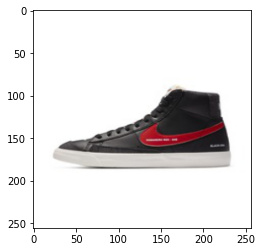

In [ ]:
class ShoesData(torch.utils.data.Dataset):
  def __init__(self, img_path, csv_path):

    self.img_path = img_path

    category_onehot = list()
    brand_onehot = list()
    price = list()

    # csvファイル読み込み
    file = open(csv_path)
    reader = csv.reader(file)
    for row in reader:
      # 数値データに変換
      row_i = [int(elem) for elem in row]
      category_onehot.append(row_i[1:11])
      brand_onehot.append(row_i[11:48])
      price.append(row_i[48])

    self.data_size = len(category_onehot)
    self.category_onehot = torch.Tensor(category_onehot)
    self.brand_onehot = torch.Tensor(brand_onehot)
    self.price = torch.Tensor(price)

  def __len__(self):
    return self.data_size

  def __getitem__(self, idx):
    transform = torchvision.transforms.Compose([
      torchvision.transforms.Resize([256, 256]),
      torchvision.transforms.ToTensor()                                              
    ])
    image = transform(Image.open(self.img_path + str(idx+1) + '.jpg').convert('RGB'))

    return image, self.category_onehot[idx], self.brand_onehot[idx], self.price[idx]

  # デバッグ用
  def showData(self, idx):
    transform = torchvision.transforms.Compose([
      torchvision.transforms.Resize([256, 256])
    ])
    image = transform(Image.open(self.img_path + str(idx+1) + '.jpg').convert('RGB'))

    print(self.category_onehot.shape)
    print(self.brand_onehot.shape)
    print(self.price.shape)

    print(self.category_onehot[idx])
    print(self.brand_onehot[idx])
    print(self.price[idx])
    plt.imshow(np.asarray(image))

dataset = ShoesData('/content/drive/MyDrive/deep/images/', '/content/drive/MyDrive/deep/onehot.csv')
dataset.showData(0)

# データセットの分割
data_size = len(dataset)
train_size = int(data_size * 0.8)
test_size = data_size - train_size

# データ数に対して割り切れるように設定する
train_batch_size = 155
test_batch_size = 110

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=test_batch_size, shuffle=True)

## 学習

ネットワーク定義

In [ ]:
activate = torch.nn.LeakyReLU()

class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # (3, 256, 256)
    self.conv11 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.conv12 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=4, stride=4)

    # (16, 64, 64)
    self.conv21 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv22 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=4, stride=4)

    # (64, 16, 16)
    self.fc1 = torch.nn.Linear(in_features=64*16*16, out_features=1024)
    self.fc2 = torch.nn.Linear(in_features=1024, out_features=512)
    self.fc3 = torch.nn.Linear(in_features=512, out_features=64)
    self.fc4 = torch.nn.Linear(in_features=64, out_features=1)

  def forward(self, x):
    x = activate(self.conv11(x))
    x = activate(self.conv12(x))
    x = self.pool1(x)
    x = activate(self.conv21(x))
    x = activate(self.conv22(x))
    x = self.pool2(x)
    x = x.view(-1, 64*16*16)
    x = activate(self.fc1(x))
    x = activate(self.fc2(x))
    x = activate(self.fc3(x))
    x = activate(self.fc4(x))
    return x[:,0]

学習

----------------------------------------
epoch : 1/10
batch : 1
batch : 2
batch : 3
batch : 4
batch : 5
batch : 6
batch : 7
batch : 8
batch : 9
batch : 10
batch : 11
batch : 12
batch : 13
batch : 14
batch : 15
batch : 16
batch : 17
batch : 18
batch : 19
batch : 20
batch : 21
batch : 22
batch : 23
batch : 24
batch : 25
batch : 26
batch : 27
batch : 28
batch : 29
batch : 30
batch : 31
batch : 32
batch : 33
batch : 34
batch : 35
batch : 36
batch : 37
batch : 38
batch : 39
batch : 40
batch : 41
batch : 42
batch : 43
batch : 44
batch : 45
batch : 46
batch : 47
batch : 48
batch : 49
batch : 50
batch : 51
batch : 52
batch : 53
batch : 54
batch : 55
batch : 56
batch : 57
batch : 58
batch : 59
batch : 60
batch : 61
batch : 62
batch : 63
batch : 64
batch : 65
batch : 66
batch : 67
batch : 68
batch : 69
batch : 70
batch : 71
batch : 72
batch : 73
batch : 74
batch : 75
batch : 76
batch : 77
batch : 78
batch : 79
batch : 80
batch : 81
batch : 82
batch : 83
batch : 84
batch : 85
batch : 86
train los

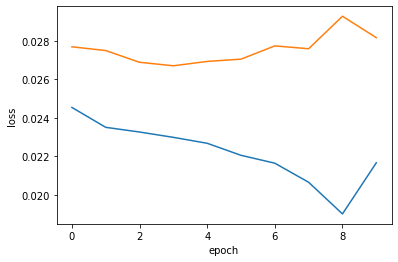

In [ ]:
model = CNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_num = 10
div_term = 100000
train_loss = []
test_loss = []

for epoch in range(epoch_num):
  print('-'*40)
  print('epoch : ' + str(epoch+1) + '/' + str(epoch_num))

  model.train()
  count = 1
  running_train_loss = 0
  for image, category, brand, price in train_loader:
    #print('batch : ' + str(count))
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, price/div_term)
    running_train_loss += loss.item()
    loss.backward()
    optimizer.step()
    count += 1
  
  train_loss.append(running_train_loss/math.sqrt(train_size))

  model.eval()
  running_test_loss = 0
  with torch.no_grad():
    for image, category, brand, price in test_loader:
      output = model(image)
      loss = criterion(output, price/div_term)
      running_test_loss += loss.item()

  test_loss.append(running_test_loss/math.sqrt(test_size))

  print('train loss : {}'.format(running_train_loss/math.sqrt(train_size)))
  print('test loss : {}'.format(running_test_loss/math.sqrt(test_size)))

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.plot(train_loss, label='train')
ax.plot(test_loss, label='test')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/deep/params/model.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/deep/params/model.pth'))


model.eval()
with torch.no_grad():
  for image, category, brand, price in test_loader:
    output = model(image)
    predict = output * normalize_term
    print('predict : ' + str(predict[0]) + ', price : ' + str(price[0]))


predict : tensor(11579.4092), price : tensor(5544.)
predict : tensor(11977.3135), price : tensor(2980.)
predict : tensor(11451.1992), price : tensor(18700.)
predict : tensor(12450.7588), price : tensor(14300.)
predict : tensor(10763.0986), price : tensor(3951.)
predict : tensor(11937.9521), price : tensor(2023.)
predict : tensor(13464.2812), price : tensor(28233.)
predict : tensor(13338.0156), price : tensor(29700.)
predict : tensor(10715.4785), price : tensor(4290.)
predict : tensor(11063.4180), price : tensor(1799.)
predict : tensor(13480.6064), price : tensor(29920.)
predict : tensor(11046.0430), price : tensor(21450.)
predict : tensor(11044.6807), price : tensor(3960.)
predict : tensor(11593.2568), price : tensor(4620.)
predict : tensor(11030.4531), price : tensor(28600.)
predict : tensor(11586.2129), price : tensor(5500.)
predict : tensor(11954.7471), price : tensor(7150.)
predict : tensor(11094.6436), price : tensor(5280.)
predict : tensor(9894.2461), price : tensor(5280.)
predic

# マルチタスク学習

## ライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

## Google Driveのマウント

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## 使用するデバイスの指定

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## その他ブランドの追加

In [ ]:
data_path = "/content/drive/MyDrive/deep/collect.csv"
data_names = ["id", "url", "category", "brand", "price"]

thresh = 100

df = pd.read_csv(data_path, names=data_names)
count = df["brand"].value_counts()

for i in range(len(df)):
  if count[df["brand"][i]] < thresh:
    df["brand"][i] = "その他"

count = df["brand"].value_counts()
print(count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


その他                     11567
LibertyDoll               667
menue                     662
NIKE                      622
SESTO                     564
HUNTER                    454
AAA+                      436
Minnetonka                426
Odette e Odile            381
AmiAmi                    372
adidas                    350
Vivian                    328
New Balance               304
ORiental TRaffic          298
EMU Australia             270
Shoes in Closet           221
Fabio Rusconi             220
JELLY BEANS               217
EVOL                      202
RANDA                     193
MAMIAN                    193
SVEC                      190
KOBE LETTUCE              184
Dedes                     184
Dr.Martens                180
NOFALL                    179
Reebok                    177
PUMA                      177
FREAK’S STORE             173
SOROTTO                   170
green label relaxing      164
chumchum                  160
CONVERSE                  157
Fin       

## ラベルの対応

In [ ]:
label_to_category = np.sort(np.unique(df["category"]))
label_to_brand = np.sort(np.unique(df["brand"]))

data_size = len(df)
category_num = len(label_to_category)
brand_num = len(label_to_brand)

category_to_label = dict()
brand_to_label = dict()

for i in range(category_num):
  category_to_label[label_to_category[i]] = i
for i in range(brand_num):
  brand_to_label[label_to_brand[i]] = i

print(label_to_category)
print(category_to_label)
print(label_to_brand)
print(brand_to_label)

['サンダル' 'スニーカー' 'スリッポン' 'ドレスシューズ' 'バレエシューズ' 'パンプス' 'ブーツ' 'モカシン/デッキシューズ'
 'レインシューズ' 'ローファー']
{'サンダル': 0, 'スニーカー': 1, 'スリッポン': 2, 'ドレスシューズ': 3, 'バレエシューズ': 4, 'パンプス': 5, 'ブーツ': 6, 'モカシン/デッキシューズ': 7, 'レインシューズ': 8, 'ローファー': 9}
['AAA+' 'AmiAmi' 'BIRKENSTOCK' 'CHARLES & KEITH' 'CONVERSE' 'Clarks'
 'Dedes' 'Dr.Martens' 'EMU Australia' 'EVOL' 'Emma Francis'
 'FREAK’S STORE' 'Fabby fabby' 'Fabio Rusconi' 'Fin' 'HARUTA' 'HUNTER'
 'JELLY BEANS' 'Jalan Sriwijaya' 'KOBE LETTUCE' 'LibertyDoll' 'MAMIAN'
 'Minnetonka' 'NIKE' 'NOFALL' 'New Balance' 'ORiental TRaffic'
 'Odette e Odile' 'PUMA' 'RANDA' 'Reebok' 'Repetto' 'SESTO' 'SOROTTO'
 'STYLEBLOCK' 'SVEC' 'Shoes in Closet' 'UGG' 'VANS' 'Vivian' 'YOSUKE'
 'adidas' 'alfredoBANNISTER' 'artemis by DIANA' 'chumchum' 'crocs'
 'green label relaxing' 'menue' 'minia' 'mooimooi' 'その他']
{'AAA+': 0, 'AmiAmi': 1, 'BIRKENSTOCK': 2, 'CHARLES & KEITH': 3, 'CONVERSE': 4, 'Clarks': 5, 'Dedes': 6, 'Dr.Martens': 7, 'EMU Australia': 8, 'EVOL': 9, 'Emma Francis': 10, 'FREAK

## データの分析

data size : 23167

price
max : 209000
min : 550
average : 11039.710968187508
median : 7590.0

category
num : 10
バレエシューズ         2400
ドレスシューズ         2400
ブーツ             2400
スリッポン           2399
ローファー           2394
サンダル            2386
レインシューズ         2383
パンプス            2375
スニーカー           2327
モカシン/デッキシューズ    1703
Name: category, dtype: int64

brand
num : 51
その他                     11567
LibertyDoll               667
menue                     662
NIKE                      622
SESTO                     564
HUNTER                    454
AAA+                      436
Minnetonka                426
Odette e Odile            381
AmiAmi                    372
adidas                    350
Vivian                    328
New Balance               304
ORiental TRaffic          298
EMU Australia             270
Shoes in Closet           221
Fabio Rusconi             220
JELLY BEANS               217
EVOL                      202
RANDA                     193
MAMIAN                    193
SVE

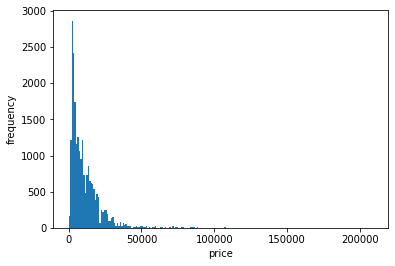

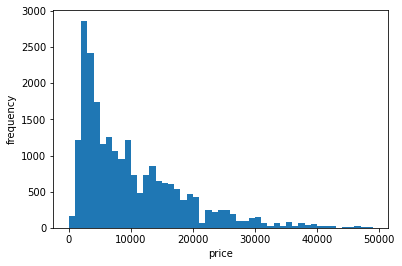

In [ ]:
maxprice = np.max(df["price"])
minprice = np.min(df["price"])
aveprice = np.average(df["price"])
medprice = np.median(df["price"])

print("data size : {}\n".format(data_size))

print("price")
print("max : {}".format(maxprice))
print("min : {}".format(minprice))
print("average : {}".format(aveprice))
print("median : {}\n".format(medprice))

print("category")
print("num : {}".format(category_num))
print(df["category"].value_counts(), end='\n\n')

print("brand")
print("num : {}".format(brand_num))
print(df["brand"].value_counts())

plt.xlabel("price")
plt.ylabel("frequency")
plt.hist(df["price"],bins=np.arange(0, 210000, 1000))
plt.figure()
plt.xlabel("price")
plt.ylabel("frequency")
plt.hist(df["price"],bins=np.arange(0, 50000, 1000))
plt.show()

最高値データの確認

209000
ローファー
その他


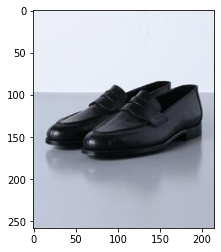

In [ ]:
idx = np.argmax(df["price"])
print(df["price"][idx])
print(df["category"][idx])
print(df["brand"][idx])
image = Image.open("/content/drive/MyDrive/deep/data/" + str(idx) + ".jpg").convert('RGB')
plt.imshow(image)

## データセット作成

price : 19800
category : スニーカー
brand : NIKE


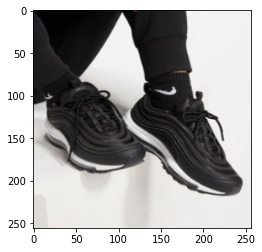

In [ ]:
class Data(Dataset):
  def __init__(self, img_dir, img_transform):
    super().__init__() 

    self.img_dir = img_dir
    self.img_transform = img_transform

    self.size = data_size
    self.id = df["id"]
    self.price = df["price"]
    self.category = df["category"]
    self.brand = df["brand"]

  def __len__(self):
    return self.size
  
  def __getitem__(self, idx):
    img = self.img_transform(Image.open(self.img_dir + str(self.id[idx]) + '.jpg').convert('RGB'))
    return img, self.price[idx], category_to_label[self.category[idx]], brand_to_label[self.brand[idx]]

img_transform = transforms.Compose([
  transforms.Resize([256, 256]),
  transforms.ToTensor()
])

dataset = Data("/content/drive/MyDrive/deep/data/", img_transform)

img, price, category_label, brand_label = dataset[0]
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}".format(label_to_brand[brand_label]))

## データセット分割

train size : 20002
test size : 3165

train batch size : 73
test batch size : 211

price : 15840
category : レインシューズ
brand : HUNTER

price : 12980
category : サンダル
brand : その他


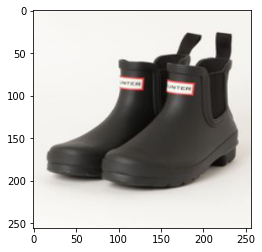

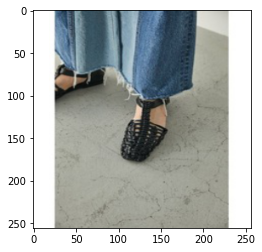

In [ ]:
train_size = 20002
test_size = data_size - train_size

print("train size : {}".format(train_size))
print("test size : {}\n".format(test_size))

# データ数に対して割り切れるように設定する
train_batch_size = 73
test_batch_size = 211

print("train batch size : {}".format(train_batch_size))
print("test batch size : {}\n".format(test_batch_size))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

img, price, category_label, brand_label = train_dataset[0]
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}\n".format(label_to_brand[brand_label]))

img, price, category_label, brand_label = test_dataset[0]
plt.figure()
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}".format(label_to_brand[brand_label]))

## ネットワーク定義

In [ ]:
class MultiTaskModel(nn.Module):
  def __init__(self, category_num, brand_num):
    super().__init__()
  
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 6, 5), nn.LeakyReLU(), nn.Conv2d(6, 12, 5), nn.LeakyReLU(), nn.MaxPool2d(4, 4),
        nn.Conv2d(12, 24, 5), nn.LeakyReLU(), nn.Conv2d(24, 48, 5), nn.LeakyReLU(), nn.MaxPool2d(3, 3),
        nn.Flatten()
    )
    
    self.price_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=1), nn.Identity()
    )
    
    self.category_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=category_num)
    )
    
    self.brand_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=brand_num)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    price = self.price_fc(x)
    category = self.category_fc(x)
    brand = self.brand_fc(x)
    
    return price, category, brand

## 損失関数

In [ ]:
# ブランドの頻度を計算し重み付け

brand_freq = np.zeros(brand_num)

indices = train_dataset.indices
for brand in df["brand"][indices].values:
  brand_freq[brand_to_label[brand]] += 1

weight = torch.Tensor(train_size / brand_freq).to(device)
print(weight)

tensor([ 52.0885,  60.6121, 224.7416, 196.0980, 146.0000, 186.9346, 128.2179,
        129.8831,  86.2155, 114.2971, 215.0753, 129.8831, 186.9346, 103.6373,
        168.0840, 177.0089,  51.2872, 108.7065, 222.2444, 124.2360,  34.4862,
        117.6588,  53.4813,  37.3869, 133.3467,  73.5368,  79.0593,  59.3531,
        129.0452, 119.7725, 121.9634, 185.2037,  40.0040, 130.7320, 240.9879,
        121.2242, 111.1222, 178.5893, 204.1020,  72.4710, 215.0753,  66.8963,
        200.0200, 224.7416, 149.2687, 169.5085, 148.1630,  35.2148, 183.5046,
        212.7872,   2.0080], device='cuda:0')


In [ ]:
price_loss_function = nn.MSELoss()
category_loss_function = nn.CrossEntropyLoss()
brand_loss_function = nn.CrossEntropyLoss(weight=weight)

## 学習

In [116]:
model = MultiTaskModel(category_num, brand_num).to(device)
optimizer = torch.optim.Adam(model.parameters())

price_div = 20000
epoch_num = 100
lambda_category = 1
lambda_brand = 1

running_train_losses = []
running_test_losses = []
# running_price_losses = []
# running_category_losses = []
# running_brand_losses = []

for epoch in range(epoch_num):
  print("\repoch : {}/{}".format(epoch+1, epoch_num), end='')

  epoch_train_loss = 0
  epoch_test_loss = 0

  model.train()
  for image, price, category, brand in train_loader:
    optimizer.zero_grad()
    
    image = image.to(device)
    price = price.view(train_batch_size, 1).to(device)
    category = category.to(device)
    brand = brand.to(device)
  
    pred_price, pred_category, pred_brand = model(image)

    price_loss = price_loss_function(pred_price, price/price_div)
    category_loss = category_loss_function(pred_category, category)
    brand_loss = brand_loss_function(pred_brand, brand)
  
    loss = price_loss
    loss += lambda_category*category_loss
    loss += lambda_brand*brand_loss
  
    loss.backward()
    optimizer.step()

    epoch_train_loss += loss.item() 
    # price_losses.append(price_loss.item()/train_batch_size)
    # category_losses.append(category_loss.item()/train_batch_size)
    # brand_losses.append(brand_loss.item()/train_batch_size)

  running_train_losses.append(epoch_train_loss/train_size)

  model.eval()
  with torch.no_grad():
    for image, price, category, brand in test_loader:

      image = image.to(device)
      price = price.view(test_batch_size, 1).to(device)
      category = category.to(device)
      brand = brand.to(device)
    
      pred_price, pred_category, pred_brand = model(image)
  
      price_loss = price_loss_function(pred_price, price/price_div)
      category_loss = category_loss_function(pred_category, category)
      brand_loss = brand_loss_function(pred_brand, brand)
    
      loss = price_loss
      loss += lambda_category*category_loss
      loss += lambda_brand*brand_loss

      epoch_test_loss += loss.item()
    
  running_test_losses.append(epoch_test_loss/test_size)

epoch : 1/100

KeyboardInterrupt: ignored

## 評価

学習曲線

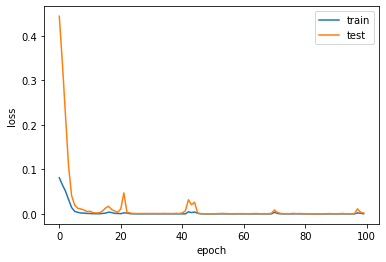

In [51]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
p1 = plt.plot(running_train_losses, label='train')
p2 = plt.plot(running_test_losses, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

In [119]:
price_error = 0

model.eval()
with torch.no_grad():
  for image, price, category_label, brand_label in test_loader:

    image = image.to(device)
    price = price.view(test_batch_size, 1).to(device)
    category = category.to(device)
    brand = brand.to(device)

    pred_price, pred_category, pred_brand = model(image)

    price_error += (price-pred_price*price_div)*(price-pred_price*price_div)

  price_error = math.sqrt(price_error/test_size)
  print(price_error.item())

KeyboardInterrupt: ignored

In [114]:
x = nn.MSELoss()
input = torch.randn(3, 1)
print(input)
target = torch.randn(3, 1)
print(target)
output = x(input, target)
print(output)

tensor([[-0.1007],
        [-0.5077],
        [ 0.1106]])
tensor([[-0.2910],
        [ 0.8666],
        [-1.2814]])
tensor(1.2876)


具体例確認

predicted price : 4244.0009117126465, true price : 6490
predicted category : パンプス, true category : パンプス
predicted brand : その他, true brand : ORiental TRaffic


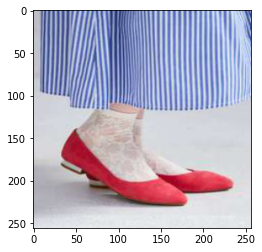

In [111]:
index = random.randint(0, test_size-1)
image, price, category_label, brand_label = test_dataset[index]
image = image.reshape(1, 3, 256, 256).to(device)

model.eval()
with torch.no_grad():
    pred_price, pred_category, pred_brand = model(image)

image = image.reshape(3, 256, 256)
image = image.cpu()
pred_category = pred_category.cpu()
pred_brand = pred_brand.cpu()

pred_category_label = np.argmax(pred_category.numpy().copy())
pred_brand_label = np.argmax(pred_brand.numpy().copy())

plt.imshow(np.asarray(image.numpy().copy().transpose(1, 2, 0)))

print("predicted price : {}, true price : {}".format(pred_price.item()*price_div, price))
print("predicted category : {}, true category : {}".format(label_to_category[pred_category_label], label_to_category[category_label]))
print("predicted brand : {}, true brand : {}".format(label_to_brand[pred_brand_label], label_to_brand[brand_label]))

## パラメータの保存

In [52]:
torch.save(model.state_dict(), '/content/drive/MyDrive/deep/params/multi.pth')